# Final Project - Deer Population Control Model Development

Authors: Tigran Melkonian, Adrian Lindsey, Louis Carpenter

## 1.Notebook Setup
### 1.a Imports

In [1]:
# Imports
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import math

def zero_to_nan(values):
    """Replace every 0 with 'nan' and return a copy."""
    return [float('nan') if x==0 else x for x in values]

### 1.b Harvesting Functions

In [2]:
# define two time-dependent hunting functions

# Gun Buck: Nov23-Dec06 (14 days)
# Archery: Sep26-Dec31 (97 days)
# Antlerless: Oct22-25, Nov23-26, Dec10-13, Dec28-31(16 days)
# Muzzleloader: Dec14-20 (7 days)
# Heritage: Jan09-12 (4 days)

def huntingDoe1(t, total_population_mortality, hunted_gender_ratio):
    daily_deer_hunted = 0
    # Archery: Sep26-Dec31 (97 days)
    if t % 365 >= 269 and t % 365 <= 365:
        daily_deer_hunted += hunted_gender_ratio*(.315 * total_population_mortality)/97
    # Antlerless: Oct22-25, Nov23-26, Dec10-13, Dec28-31(16 days)
    if t % 365 >= 295 and t % 365 <= 298 or t % 365 >= 327 and t % 365 <= 330 or t % 365 >= 344 and t % 365 <= 347 or t % 365 >= 362 and t % 365 <= 365:
        daily_deer_hunted += (.302 * total_population_mortality)/16
    # Muzzleloader: Dec14-20 (7 days)
    if t % 348 >= 348 and t % 354 <= 354:
        daily_deer_hunted += hunted_gender_ratio*(.046 * total_population_mortality)/7
    # Heritage: Jan09-12 (4 days)
    if t % 9 >= 9 and t % 12 <= 12:
        daily_deer_hunted += hunted_gender_ratio*(.005 * total_population_mortality)/4
    return daily_deer_hunted

def huntingBuck1(t, total_population_mortality, hunted_gender_ratio):
    daily_deer_hunted = 0
    # Gun Buck: Nov23-Dec06 (14 days)
    if t % 365 >= 327 and t % 365 <= 341:
        daily_deer_hunted += (.332 * total_population_mortality)/14
    # Archery: Sep26-Dec31 (97 days)
    if t % 365 >= 269 and t % 365 <= 365:
        daily_deer_hunted += hunted_gender_ratio*(.315 * total_population_mortality)/97
    # Muzzleloader: Dec14-20 (7 days)
    if t % 348 >= 348 and t % 354 <= 354:
        daily_deer_hunted += hunted_gender_ratio*(.046 * total_population_mortality)/7
    # Heritage: Jan09-12 (4 days)
    if t % 9 >= 9 and t % 12 <= 12:
        daily_deer_hunted += hunted_gender_ratio*(.005 * total_population_mortality)/4
    return daily_deer_hunted


### 1.c Birthing Function

In [3]:
#define time-dependent birth function
def birth(t):
    brith_rate = 1.83/365
    # Spring runs from March 1 to May 31;
    # Summer runs from June 1 to August 31;
    if t % 365 >= 60 and t % 365 <= 243:
        return 1.75 * brith_rate 
    else: 
        return .25 * brith_rate 

### 1.d Model Parameters #

- **t**                  --Time (time in days - 18250 days = 50 years)
- **K**                  --Carrying capacity(Total deer populatino carrying capacity) ~ 700,000 in West Virginia
- **C**                  -- Deer vehicle colissions(Deer vehicle collisions per day) ~ 8000/yr -> 22/day in West Virginia
- **d**                  --Death rate(Natural deer death rate) ~ 15 percent .2 of the total deer population naturally dies off
- **m**                  --District hunting quota (Hunting quota as a percent of the total deer population) ~ 3.68% of a 550000 deer pop.
- **P_f**                --(Female deer population)
- **P_m**                --(Male deer population)
- **P**                  --(Total deer population)
- **hbr**                --(Ratio of munting mortaities that were Bucks) - hdr = 1- hbr
- **rf**                 --(Scalar factor that ranges from .5 to 1.5 depending on time of year that represents deer roaming behavior)
- **pr**                 --(District specific ratio of total WV deer population) ~ derived from total observed deer mortalities in a district / total observed deer mortalities in WV


### 1.e Test Deer Model Setup

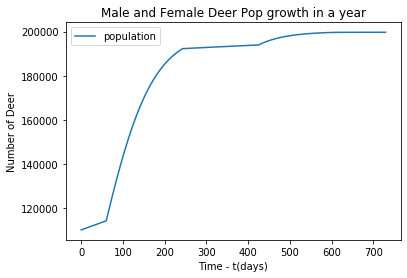

In [7]:
## ## Convincing that a 1.8 growth rate value leads to 80 percent growth as opposed to .85 #
## ## considering undrestricted growth with a >> K value~ K = 1000000           ###
#############################################################################################
# define main model
# spring and summer deer survivial rates .97 female .98 male
# fall
# winter 

# On the road again: Deer move more during the breeding season (October-December) than any other time of year,
# so watch out for them as you drive. Slow down and stay alert! 
def deerModelTest(X,t,K,C,d,mortality,hbr,rf): 
    P_f,P_m = X
    P = P_f + P_m
    r_max = birth(t)*(1 - abs(P_f-P_m)/P) - (d/365)
    hdr = 1 - hbr  
    msr = .98
    fsr = .97 
        
    # Spring and Summer 
    if t % 365 >= 60 and t % 365 <= 243:
        msr = .98
        fsr = .97
        rf = rf
    # Fall
    if t % 365 >= 265 and t % 365 <= 355:
        msr = .95
        fsr = .94
        rf = 1.5*rf
    # Winter
    if t % 365 >= 356 and t % 365 <= 59:
        msr = .78
        fsr = .77
        rf = .6*rf
        
    if P_f <= 0: 
        dP_f = 0
    else: 
        dP_f = r_max*fsr*(P*(1-(P/(K)))) #- huntingDoe1(t,mortality*P, hdr) - ((P_f/P)*rf*C)
    if P_m <= 0: 
        dP_m = 0
    else:
        dP_m = r_max*msr*(P*(1-(P/(K)))) #- huntingBuck1(t,mortality*P, hbr) - ((P_m/P)*rf*C) 
    
    return [dP_f, dP_m]

t = np.linspace(0,2*365,2*365) # 18250 days  or 50 years
K,C,d,mortality,hbr,rf = [.2*1000000,.2*22,.2,.18,.6,1]

sol = odeint(deerModelTest, [.2*275000, .2*275000], t, args = (K,C,d,mortality,hbr,rf,))

#plt.plot(sol[:,0], label = "female")
#plt.plot(sol[:,1],  label = "male")
plt.plot(sol[:,0] + sol[:,1],  label = "population")



plt.title('Male and Female Deer Pop growth in a year')
plt.xlabel('Time - t(days)')
plt.ylabel('Number of Deer')
plt.legend()

### 1.f Baseline Deer Model

In [47]:
# define main model
# spring and summer deer survivial rates .97 female .98 male
# fall
# winter 

# total population starts at 110,000 for all scenarios in D1
total_pop = 11E4

# On the road again: Deer move more during the breeding season (October-December) than any other time of year,
# so watch out for them as you drive. Slow down and stay alert! 
def deerModel(X,t,K,C,d,mortality,hbr,rf): 
    P_f,P_m = X
    P = P_f + P_m
    r_max = birth(t)*(1 - abs(P_f-P_m)/P) - (d/365)
    hdr = 1 - hbr  
    msr = .98
    fsr = .97 
        
    # Spring and Summer 
    if t % 365 >= 60 and t % 365 <= 243:
        msr = .98
        fsr = .97
        rf = rf
    # Fall
    if t % 365 >= 265 and t % 365 <= 355:
        msr = .95
        fsr = .94
        rf = 1.5*rf
    # Winter
    if t % 365 >= 356 and t % 365 <= 59:
        msr = .78
        fsr = .77
        rf = .6*rf
        
    if P_f <= 0: 
        dP_f = 0
    else: 
        dP_f = r_max*fsr*(P*(1-(P/(K)))) - huntingDoe1(t,mortality*P, hdr) - ((P_f/P)*rf*C)
    if P_m <= 0: 
        dP_m = 0
    else:
        dP_m = r_max*msr*(P*(1-(P/(K)))) - huntingBuck1(t,mortality*P, hbr) - ((P_m/P)*rf*C) 
    
    return [dP_f, dP_m]

<hr style="border:1px solid gray"> </hr>

## 2 Analysis of Even Population Split 

#### K,C,d,mortality,hbr,rf = [0.2(700000),0.2(22),0.2,0.18,0.6,1]
#### Female (1) : Male (1)

### 2.1 Baseline Herd Survival for 1:1 Ratio

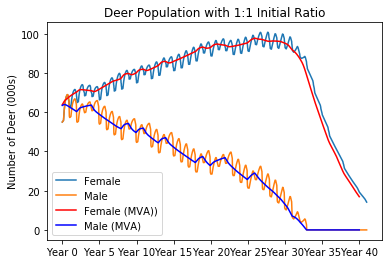

In [54]:
## ## Initalized with equal male/female populations #
#################################################
yrs = 41

t = np.linspace(0,365*yrs,365*yrs) # 18250 days  or 50 years
K,C,d,mortality,hbr,rf = [.2*700000,.2*22,.2,.18,.6,1]

f_ratio = 1
m_ratio = 1

sol = odeint(deerModel, 
             [round(f_ratio*total_pop/(f_ratio + m_ratio),0), 
              round(m_ratio*total_pop/(f_ratio + m_ratio),0)], 
             t, args = (K,C,d,mortality,hbr,rf,))/1e3

plt.title('Deer Population with 1:1 Initial Ratio')

## plot features
plt.plot(sol[:,0], label = "Female")
plt.plot(sol[:,1],  label = "Male")

mva_female = np.convolve(sol[:,0], np.ones((365,))/365, mode='valid')
plt.plot(mva_female, label = "Female (MVA))", color = 'red')

mva_male = np.convolve(sol[:,1], np.ones((365,))/365, mode='valid')
plt.plot(mva_male, label = "Male (MVA)", color = 'blue')
plt.legend()

plt.ylabel('Number of Deer (000s)')

x_ticks = [day for day in range(0,365*yrs,1) if day%(365*5) == 0] # Only pull out full years
x_labels = ['Year ' + str(i*5) for i in range(len(x_ticks))]
plt.xticks(x_ticks, x_labels)
plt.show()

Note with the given parameters above, the total deer population dies off in about 31 years. This is obviously not a stable system and we can already suggest a management method of reducing the year after year hunting quota to a fraction of the 18 percent (20233 deers hunted) observed in District 1 in west virginia. Lets now  vary **hbr** to understand whether there exists a set of conditions that leads to a hundred year herd (i.e. both the male and female populations survive (are not zero by the 100th year) while fixing the hunting quota to 18 percent. 

### 2.2 Analyze HBR Sensitivity for 1:1 Ratio

In [57]:
total_pop

110000.0

In [55]:
yrs = 100

sol = []
f_ratio = 1
m_ratio = 1
for rate in range(10,60,5):
    
    t = np.linspace(0,365*yrs,365*yrs) # 18250 days  or 50 years
    K,C,d,mortality,hbr,rf = [.2*700000,.2*22,.2,.18,(rate/100),1]

    sol.append(odeint(deerModel, 
                      [round(f_ratio*total_pop/(f_ratio + m_ratio),0), 
                       round(m_ratio*total_pop/(f_ratio + m_ratio),0)],  
                      t, args = (K,C,d,mortality,hbr,rf,))/1e3)

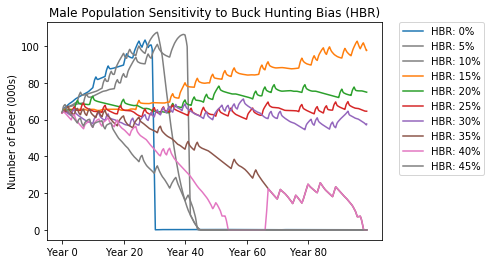

In [58]:
male = [item[:,1] for item in sol]
#plt.plot(male[2])
for i in range(len(male)):
    mva_male = np.convolve(male[i], np.ones((365,))/365, mode='valid') #str((i*5+20))
    if (mva_male[30000]>0):
        plt.plot(mva_male, label = ("HBR: " + str(i*5) + "%"))
    else: plt.plot(mva_male, label = ("HBR: " + str(i*5) + "%"), color = "gray") 
        
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.title('Male Population Sensitivity to Buck Hunting Bias (HBR)')


    plt.ylabel('Number of Deer (000s)')

    x_ticks = [day for day in range(0,365*yrs,1) if day%(365*20) == 0] # Only pull out full years
    x_labels = ['Year ' + str(i*20) for i in range(len(x_ticks))]
    plt.xticks(x_ticks, x_labels)

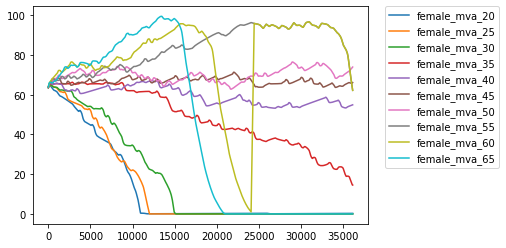

In [59]:
female = [item[:,0]  for item in sol]
for i in range(len(female)):
    mva_female = np.convolve(female[i], np.ones((365,))/365, mode='valid')
    plt.plot(mva_female, label = ("female_mva_" + str((i*5+20))))
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

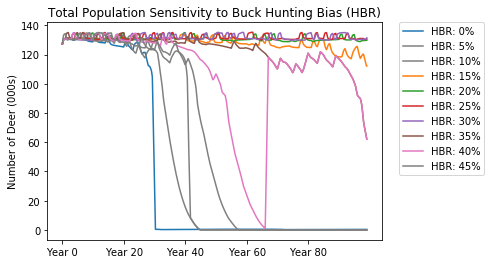

In [60]:
for i in range(len(female)):
    total = male[i] + female[i]
    mva_total = np.convolve(total, np.ones((365,))/365, mode='valid')
    if (mva_total[30000]>0):
        plt.plot(mva_total, label = ("HBR: " + str((i*5)) + "%"))
    else: plt.plot(mva_total, label = ("HBR: " + str((i*5)) + "%"), color = "gray")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.title('Total Population Sensitivity to Buck Hunting Bias (HBR)')
    
    plt.ylabel('Number of Deer (000s)')

    x_ticks = [day for day in range(0,365*yrs,1) if day%(365*20) == 0] # Only pull out full years
    x_labels = ['Year ' + str(i*20) for i in range(len(x_ticks))]
    plt.xticks(x_ticks, x_labels)
    

<hr style="border:1px solid gray"> </hr>

### 2.3 5-Year Dampening Function

Now, What if every five years we significantly decrease mortality rate m from 18 percent to 3-5 percent for one year to let the population bounce back - goal is to dampen effect of high hunting buck ratio i.e. obtain a wider **hbr** range that better suits population demand. 

In [61]:
# determines whether a given timepoint is a fifth year - takes in a year int value
def isFifthYear(year):
    if (year % 5) == 0 and year != 0:
        if (year % 100) == 0:
            if (year % 500) == 0:
                return True
            else:
                return False
        else:
             return True
    else:
        return False

In [62]:
# first dampened hunting model with five year dampening period that reduces the mortality to .2(.18)
def deerModelDampenedHunting(X,t,K,C,d,mortality,hbr,rf): 
    P_f,P_m = X
    P = P_f + P_m
    r_max = birth(t)*(1 - abs(P_f-P_m)/P) - (d/365)
    hdr = 1 - hbr  
    msr = .98
    fsr = .97 
        
    # Spring and Summer 
    if t % 365 >= 60 and t % 365 <= 243:
        msr = .98
        fsr = .97
        rf = rf
    # Fall
    if t % 365 >= 265 and t % 365 <= 355:
        msr = .95
        fsr = .94
        rf = 1.5*rf
    # Winter
    if t % 365 >= 356 and t % 365 <= 59:
        msr = .78
        fsr = .77
        rf = .6*rf
        
    if P_f <= 0: 
        dP_f = 0
    else: 
        if (isFifthYear(math.floor(t/365))):
            dP_f = r_max*fsr*(P*(1-(P/(K)))) - huntingDoe1(t,.2*mortality*P, hdr) - ((P_f/P)*rf*C)
        else:
            dP_f = r_max*fsr*(P*(1-(P/(K)))) - huntingDoe1(t,mortality*P, hdr) - ((P_f/P)*rf*C)
    if P_m <= 0: 
        dP_m = 0
    else:
        if (isFifthYear(math.floor(t/365))):
            dP_m = r_max*msr*(P*(1-(P/(K)))) - huntingBuck1(t,.2*mortality*P, hbr) - ((P_m/P)*rf*C) 
        else: 
            dP_m = r_max*msr*(P*(1-(P/(K)))) - huntingBuck1(t,mortality*P, hbr) - ((P_m/P)*rf*C) 
    
    return [dP_f, dP_m]

### 2.4 5-Year Dampening Baseline for 1:1 Ratio

([<matplotlib.axis.XTick at 0x28c3da86088>,
 <a list of 5 Text xticklabel objects>)

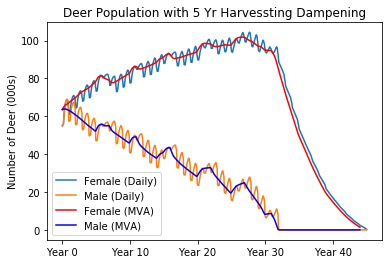

In [10]:
## ## Initalized with equal male/female populations #
#################################################
yrs = 45
t = np.linspace(0,365*yrs,365*yrs) 
K,C,d,mortality,hbr,rf = [.2*700000,.2*22,.2,.18,.6,1]

f_ratio = 1
m_ratio = 1

sol = odeint(deerModelDampenedHunting, 
             [round(f_ratio*total_pop/(f_ratio + m_ratio),0), 
              round(m_ratio*total_pop/(f_ratio + m_ratio),0)], 
             t, args = (K,C,d,mortality,hbr,rf,))/1e3

plt.plot(sol[:,0], label = "Female (Daily)")
plt.plot(sol[:,1],  label = "Male (Daily)")

mva_female = np.convolve(sol[:,0], np.ones((365,))/365, mode='valid')
plt.plot(mva_female, label = "Female (MVA)", color = 'red')

mva_male = np.convolve(sol[:,1], np.ones((365,))/365, mode='valid')
plt.plot(mva_male, label = "Male (MVA)", color = 'blue')

plt.title('Deer Population with 5 Yr Harvessting Dampening')

plt.legend()

plt.ylabel('Number of Deer (000s)')

x_ticks = [day for day in range(0,365*yrs,1) if day%(365*10) == 0] # Only pull out full years
x_labels = ['Year ' + str(i*10) for i in range(len(x_ticks))]
plt.xticks(x_ticks, x_labels)

Note with the given parameters above, the total deer population now dies off in about 43 years, this method leads to a deer population that survives for 12 years longer than the system with no dampening from above. This is still not a stable system. Lets now  vary **hbr** to understand whether there exists a set of conditions that leads to a hundred year herd (i.e. both the male and female populations survive (are not zero by the 100th year) while fixing the hunting quota to .18 and .2(.18) every fifth year. 

### 2.5 Analyze HBR Sensitivity for 5-Year Dampening for 1:1 Ratio

In [63]:
sol = []
for rate in range(10,60,5):
    yrs = 100
    t = np.linspace(0,365*yrs,365*yrs) 
    K,C,d,mortality,hbr,rf = [.2*700000,.2*22,.2,.18,(rate/100),1]

    sol.append(odeint(deerModelDampenedHunting, 
                      [round(f_ratio*total_pop/(f_ratio + m_ratio),0), 
                       round(m_ratio*total_pop/(f_ratio + m_ratio),0)], 
                      t, args = (K,C,d,mortality,hbr,rf,))/1e3)

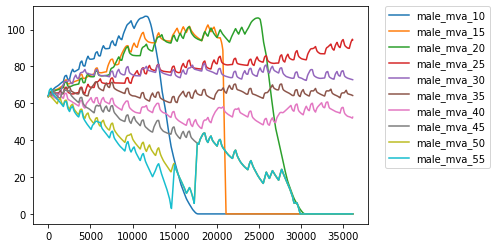

In [64]:
male = [item[:,1] for item in sol]
#plt.plot(male[2])
for i in range(len(male)):
    mva_male = np.convolve(male[i], np.ones((365,))/365, mode='valid')
    plt.plot(mva_male, label = ("male_mva_" + str(i*5+10)))
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

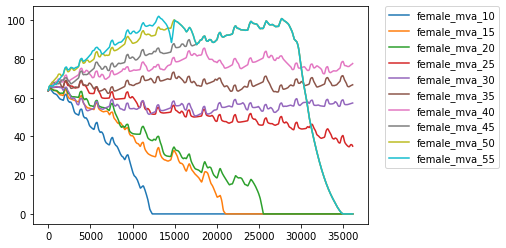

In [65]:
female = [item[:,0]  for item in sol]
for i in range(len(female)):
    mva_female = np.convolve(female[i], np.ones((365,))/365, mode='valid')
    plt.plot(mva_female, label = ("female_mva_" + str(i*5+10)))
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

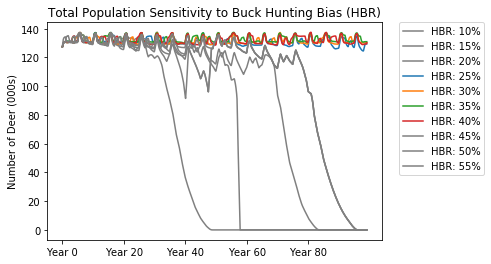

In [66]:
for i in range(len(female)):
    total = male[i] + female[i]
    mva_total = np.convolve(total, np.ones((365,))/365, mode='valid')
#     plt.plot(mva_total, label = ("total_mva_" + str(i*5 + 10)))
#     plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    
    if (mva_total[len(mva_total)-1]>10):
        plt.plot(mva_total, label = ("HBR: " + str((i*5 + 10)) + "%"))
    else: plt.plot(mva_total, label = ("HBR: " + str((i*5 + 10)) + "%"), color = "gray")#, alpha = 0.5)
        
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.title('Total Population Sensitivity to Buck Hunting Bias (HBR)')
    
    plt.ylabel('Number of Deer (000s)')

    x_ticks = [day for day in range(0,365*yrs,1) if day%(365*20) == 0] # Only pull out full years
    x_labels = ['Year ' + str(i*20) for i in range(len(x_ticks))]
    plt.xticks(x_ticks, x_labels)

Given the initial 50/50 population split and the input parameters from above, if there is demand for an 18 percent hunting quota driven by an economic point of view or human population sustainability point of view then an hbr that falls within the range .25-.44 leads to a stable 100 year herd.

<hr style="border:1px solid gray"> </hr>

### 2.6 2-Year Dampening Function

What if every two years we significantly decrease mortality rate m from 18 percent to 3-5 percent for one year to let the population bounce back - goal is to dampen effect of high hunting buck ratio i.e. .6 or greater. 

In [67]:
def isSecondYear(year):
    if (year % 2) == 0 and year != 0:
        if (year % 100) == 0:
            if (year % 200) == 0:
                return True
            else:
                return False
        else:
             return True
    else:
        return False

In [68]:
# define main model
# spring and summer deer survivial rates .97 female .98 male
# fall
# winter 

# On the road again: Deer move more during the breeding season (October-December) than any other time of year,
# so watch out for them as you drive. Slow down and stay alert! 
def deerModelDampenedHunting2(X,t,K,C,d,mortality,hbr,rf): 
    P_f,P_m = X
    P = P_f + P_m
    r_max = birth(t)*(1 - abs(P_f-P_m)/P) - (d/365)
    hdr = 1 - hbr  
    msr = .98
    fsr = .97 
        
    # Spring and Summer 
    if t % 365 >= 60 and t % 365 <= 243:
        msr = .98
        fsr = .97
        rf = rf
    # Fall
    if t % 365 >= 265 and t % 365 <= 355:
        msr = .95
        fsr = .94
        rf = 1.5*rf
    # Winter
    if t % 365 >= 356 and t % 365 <= 59:
        msr = .78
        fsr = .77
        rf = .6*rf
        
    if P_f <= 0: 
        dP_f = 0
    else: 
        if (isSecondYear(math.floor(t/365))):
            dP_f = r_max*fsr*(P*(1-(P/(K)))) - huntingDoe1(t,.2*mortality*P, hdr) - ((P_f/P)*rf*C)
        else:
            dP_f = r_max*fsr*(P*(1-(P/(K)))) - huntingDoe1(t,mortality*P, hdr) - ((P_f/P)*rf*C)
    if P_m <= 0: 
        dP_m = 0
    else:
        if (isSecondYear(math.floor(t/365))):
            dP_m = r_max*msr*(P*(1-(P/(K)))) - huntingBuck1(t,.2*mortality*P, hbr) - ((P_m/P)*rf*C) 
        else: 
            dP_m = r_max*msr*(P*(1-(P/(K)))) - huntingBuck1(t,mortality*P, hbr) - ((P_m/P)*rf*C) 
    
    return [dP_f, dP_m]

### 2.7 2-Year Dampening Baseline for 1:1 Ratio

([<matplotlib.axis.XTick at 0x28c3ffd4e88>,
 <a list of 4 Text xticklabel objects>)

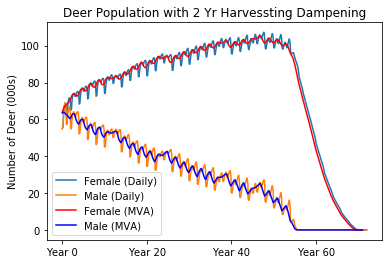

In [15]:
## ## Initalized with equal male/female populations #
#################################################
yrs = 72

t = np.linspace(0,365*yrs,365*yrs) # 18250 days  or 50 years
K,C,d,mortality,hbr,rf = [.2*700000,.2*22,.2,.18,.6,1]

sol = odeint(deerModelDampenedHunting2, 
             [round(f_ratio*total_pop/(f_ratio + m_ratio),0), 
              round(m_ratio*total_pop/(f_ratio + m_ratio),0)],
             t, args = (K,C,d,mortality,hbr,rf,))/1e3

plt.plot(sol[:,0], label = "Female (Daily)")
plt.plot(sol[:,1],  label = "Male (Daily)")
#plt.plot(sol[:,0] + sol[:,1],  label = "population")

mva_female = np.convolve(sol[:,0], np.ones((365,))/365, mode='valid')
plt.plot(mva_female, label = "Female (MVA)", color = 'red')

mva_male = np.convolve(sol[:,1], np.ones((365,))/365, mode='valid')
plt.plot(mva_male, label = "Male (MVA)", color = 'blue')

plt.title('Deer Population with 2 Yr Harvessting Dampening')

plt.legend()

plt.ylabel('Number of Deer (000s)')

x_ticks = [day for day in range(0,365*yrs,1) if day%(365*20) == 0] # Only pull out full years
x_labels = ['Year ' + str(i*20) for i in range(len(x_ticks))]
plt.xticks(x_ticks, x_labels)

### 2.8 Analyze HBR Sensitivity for 2-Year Dampening for 1:1 Ratio

In [252]:
sol = []
yrs = 100
for rate in range(10,60,5):
    
    t = np.linspace(0,365*yrs,365*yrs) 
    K,C,d,mortality,hbr,rf = [.2*700000,.2*22,.2,.18,(rate/100),1]

    sol.append(odeint(deerModelDampenedHunting2, 
             [round(f_ratio*total_pop/(f_ratio + m_ratio),0), 
              round(m_ratio*total_pop/(f_ratio + m_ratio),0)],
             t, args = (K,C,d,mortality,hbr,rf,))/1e3)

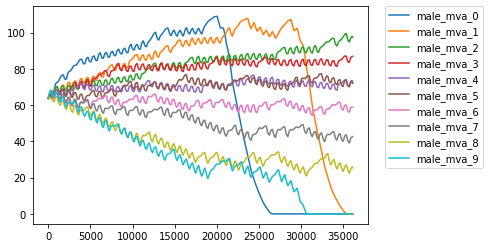

In [253]:
male = [item[:,1] for item in sol]
#plt.plot(male[2])
for i in range(len(male)):
    mva_male = np.convolve(male[i], np.ones((365,))/365, mode='valid')
    plt.plot(mva_male, label = ("male_mva_" + str(i)))
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

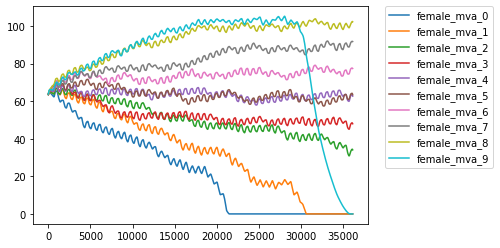

In [254]:
female = [item[:,0]  for item in sol]
for i in range(len(female)):
    mva_female = np.convolve(female[i], np.ones((365,))/365, mode='valid')
    plt.plot(mva_female, label = ("female_mva_" + str(i)))
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

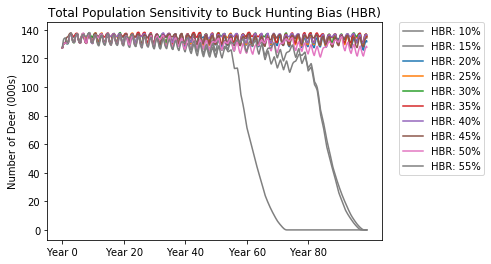

In [256]:
for i in range(len(female)):
    total = male[i] + female[i]
    mva_total = np.convolve(total, np.ones((365,))/365, mode='valid')
    
    mva_total = zero_to_nan(mva_total)
    
    if (mva_total[len(mva_total)-1]>10):
        plt.plot(mva_total, label = ("HBR: " + str((i*5 + 10)) + "%"))
    else: plt.plot(mva_total, label = ("HBR: " + str((i*5 + 10)) + "%"), color = "gray")
        
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.title('Total Population Sensitivity to Buck Hunting Bias (HBR)')
    plt.ylabel('Number of Deer (000s)')

    x_ticks = [day for day in range(0,365*yrs,1) if day%(365*20) == 0] # Only pull out full years
    x_labels = ['Year ' + str(i*20) for i in range(len(x_ticks))]
    plt.xticks(x_ticks, x_labels)

Dampening the hunting every two years seems to lead to the most stable system. An **hbr** value from .1-.9 now allow for hundred year herds. 

dampening every n years might be hard to sell, instead why dont we try to mimic the results of the two year dampening system via a smaller year after year hunting quota 

i havent done the math but adrian had the numbers down in our last meeting

why not just reduce 18 percent for each year instead of .2 every two or five years (more sellable mamagement method)

### 2.9 100 Year Herd Analysis for 1:1 Ratio

In [230]:
# 27, 28, 29, 30 lead to stable total populations & 41-44 - make note of whichof these leads to the most even pop split in 100 years

# hbr of 27 - 44 lead to stable populations w/ equal initial population split and 18 percent mortality


# Given the initial 50/50 population split and the input parameters from above, if there is demand for 
# an 18 percent hunting quota driven by an economic point of view or human population sustainability point of view then an **hbr** that falls within the range .27-.44 leads to a stable 100 year herd. 

print("bhr min adjust: " + str(0.6 - 0.35)) # change buck hunting bias by 20% YEARLY
print("bhr max adjust: " + str(0.6 - 0.15)) # change buck hunting bias by 20% YEARLY
print("hunt adjust: " + str((0.18 - (0.18 * 0.2))*0.5)) # or change overall hunting behavior by 7.2% YEARLY

## We would need to decrease our buck hunting bias ratio by 25 pct points to get to our minimally viable 
# 100 Year Herd and not more than 45 pct point else our herd population quickly falls to zero before year 80.

## Given a 2 year harvesting dampending strategy (80% reduction in harvesting mortality every other year), 
# we would need to adjst our buck hunting bias ratio by only 20 pct points to get to our minimally 
# viable 100 Year Herd.
# Notice that the 2 year harvesting strategy reduces total deer harvest by 40% annually.

bhr min adjust: 0.25
bhr max adjust: 0.44999999999999996
hunt adjust: 0.072


<hr style="border:1px solid gray"> </hr>

## 3 Analysis of 4:1 Population Split 

#### K,C,d,mortality,hbr,rf = [.2(700000),.2(22),.2,.18,.6,1]

#### Female (4) : Male (1)

Running through same plots as above. I will not comment on them, I just want to produce them and will highlight some noteworthy points 

### 3.1 Baseline Herd Survival for 4:1 Ratio

In [76]:
f_ratio = 4
m_ratio = 1


([<matplotlib.axis.XTick at 0x28c4bb7af08>,
 <a list of 6 Text xticklabel objects>)

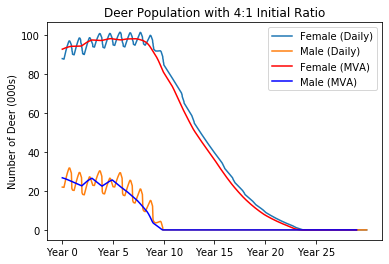

In [69]:
## ## Initalized with equal male/female populations #
#################################################
yrs = 30

t = np.linspace(0,365*yrs,365*yrs) 
K,C,d,mortality,hbr,rf = [.2*700000,.2*22,.2,.18,.6,1]

f_ratio = 4
m_ratio = 1

sol = odeint(deerModel, [round(f_ratio*total_pop/(f_ratio + m_ratio),0), 
                         round(m_ratio*total_pop/(f_ratio + m_ratio),0)], 
             t, args = (K,C,d,mortality,hbr,rf,))/1e3
# sol = odeint(deerModel, [91667, 18333], t, args = (K,C,d,mortality,hbr,rf,))


plt.plot(sol[:,0], label = "Female (Daily)")
plt.plot(sol[:,1],  label = "Male (Daily)")
#plt.plot(sol[:,0] + sol[:,1],  label = "population")

mva_female = np.convolve(sol[:,0], np.ones((365,))/365, mode='valid')
plt.plot(mva_female, label = "Female (MVA)", color = 'red')

mva_male = np.convolve(sol[:,1], np.ones((365,))/365, mode='valid')
plt.plot(mva_male, label = "Male (MVA)", color = 'blue')

plt.title('Deer Population with 4:1 Initial Ratio')
# plt.xlabel('Time - t(days)')
# plt.ylabel('Number of Deer')
# x_ticks = np.arange(0, 365*30, 365*5)
# plt.xticks(x_ticks)
plt.legend()

plt.ylabel('Number of Deer (000s)')

x_ticks = [day for day in range(0,365*yrs,1) if day%(365*5) == 0] # Only pull out full years
x_labels = ['Year ' + str(i*5) for i in range(len(x_ticks))]
plt.xticks(x_ticks, x_labels)

### 3.2 Analyze HBR Sensitivity for Baseline for 4:1 Ratio

In [70]:
sol = []
yrs = 100
for rate in range(10,60,5):
    
    t = np.linspace(0,365*100,365*100) # 18250 days  or 50 years
    K,C,d,mortality,hbr,rf = [.2*700000,.2*22,.2,.18,(rate/100),1]

    sol.append(odeint(deerModel, [round(f_ratio*total_pop/(f_ratio + m_ratio),0), 
                                  round(m_ratio*total_pop/(f_ratio + m_ratio),0)],
                      t, args = (K,C,d,mortality,hbr,rf,))/1e3)

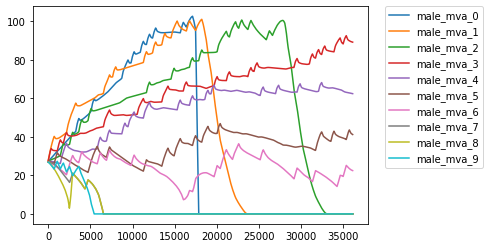

In [71]:
male = [item[:,1] for item in sol]
#plt.plot(male[2])
for i in range(len(male)):
    mva_male = np.convolve(male[i], np.ones((365,))/365, mode='valid')
    plt.plot(mva_male, label = ("male_mva_" + str(i)))
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

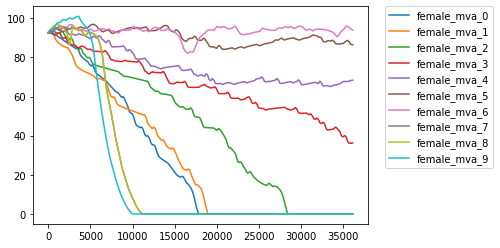

In [72]:
female = [item[:,0]  for item in sol]
for i in range(len(female)):
    mva_female = np.convolve(female[i], np.ones((365,))/365, mode='valid')
    plt.plot(mva_female, label = ("female_mva_" + str(i)))
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

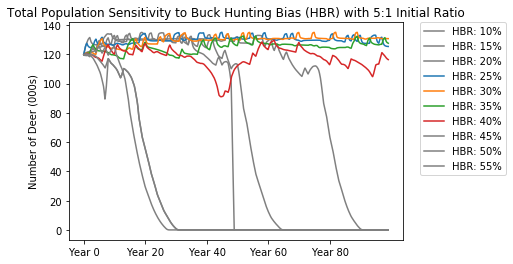

In [73]:
for i in range(len(female)):
    total = male[i] + female[i]
    mva_total = np.convolve(total, np.ones((365,))/365, mode='valid')
    
    mva_total = zero_to_nan(mva_total)
    
    if (mva_total[len(mva_total)-1]>0):
        plt.plot(mva_total, label = ("HBR: " + str((i*5 + 10)) + "%"))
    else: plt.plot(mva_total, label = ("HBR: " + str((i*5 + 10)) + "%"), color = "gray")#, alpha = 0.5)
        
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.title('Total Population Sensitivity to Buck Hunting Bias (HBR) with 5:1 Initial Ratio')
    plt.ylabel('Number of Deer (000s)')

    x_ticks = [day for day in range(0,365*yrs,1) if day%(365*20) == 0] # Only pull out full years
    x_labels = ['Year ' + str(i*20) for i in range(len(x_ticks))]
    plt.xticks(x_ticks, x_labels)
    
    
#     plt.plot(mva_total, label = ("total_mva_" + str(i)))
#     plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

<hr style="border:1px solid gray"> </hr>

### 3.3 5-Year Dampening for 4:1 Ratio


4 1


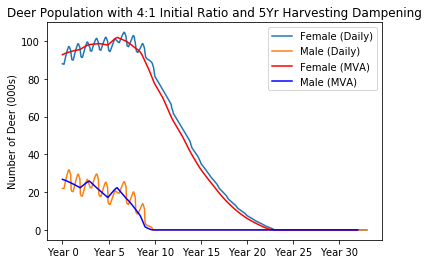

In [74]:
## ## Initalized with equal male/female populations #
#################################################
yrs = 33

t = np.linspace(0,365*yrs,365*yrs) # 18250 days  or 50 years
K,C,d,mortality,hbr,rf = [.2*700000,.2*22,.2,.18,.6,1]

sol = odeint(deerModelDampenedHunting, 
             [round(f_ratio*total_pop/(f_ratio + m_ratio),0), 
              round(m_ratio*total_pop/(f_ratio + m_ratio),0)],
             t, args = (K,C,d,mortality,hbr,rf,))/1e3


plt.plot(sol[:,0], label = "Female (Daily)")
plt.plot(sol[:,1],  label = "Male (Daily)")
#plt.plot(sol[:,0] + sol[:,1],  label = "population")

mva_female = np.convolve(sol[:,0], np.ones((365,))/365, mode='valid')
plt.plot(mva_female, label = "Female (MVA)", color = 'red')

mva_male = np.convolve(sol[:,1], np.ones((365,))/365, mode='valid')
plt.plot(mva_male, label = "Male (MVA)", color = 'blue')

plt.title('Deer Population with 4:1 Initial Ratio and 5Yr Harvesting Dampening')
plt.ylabel('Number of Deer (000s)')

x_ticks = [day for day in range(0,365*yrs,1) if day%(365*5) == 0] # Only pull out full years
x_labels = ['Year ' + str(i*5) for i in range(len(x_ticks))]
plt.xticks(x_ticks, x_labels)
plt.legend()

print(f_ratio, m_ratio)

### 3.4 Analze HBR Sensitivity for 5-Year Dampening for 4:1 Ratio

In [88]:
sol = []
yrs = 100
for rate in range(10,60,5):
    
    t = np.linspace(0,365*100,365*100) # 18250 days  or 50 years
    K,C,d,mortality,hbr,rf = [.2*700000,.2*22,.2,.18,(rate/100),1]

    sol.append(odeint(deerModelDampenedHunting, 
             [round(f_ratio*total_pop/(f_ratio + m_ratio),0), 
              round(m_ratio*total_pop/(f_ratio + m_ratio),0)],
             t, args = (K,C,d,mortality,hbr,rf,))/1e3)

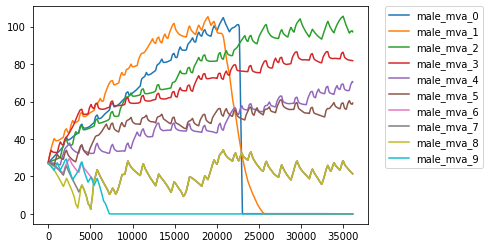

In [89]:
male = [item[:,1] for item in sol]
#plt.plot(male[2])
for i in range(len(male)):
    mva_male = np.convolve(male[i], np.ones((365,))/365, mode='valid')
    plt.plot(mva_male, label = ("male_mva_" + str(i)))
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

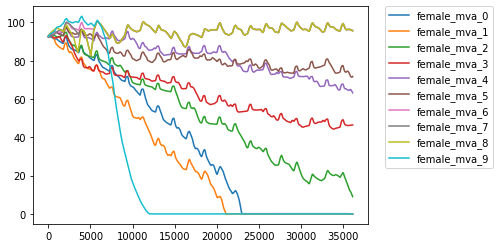

In [90]:
female = [item[:,0]  for item in sol]
for i in range(len(female)):
    mva_female = np.convolve(female[i], np.ones((365,))/365, mode='valid')
    plt.plot(mva_female, label = ("female_mva_" + str(i)))
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

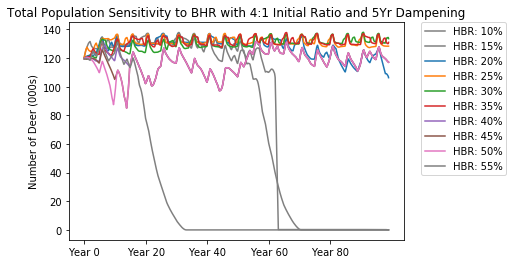

In [92]:
for i in range(len(female)):
    total = male[i] + female[i]
    mva_total = np.convolve(total, np.ones((365,))/365, mode='valid')
    
    mva_total = zero_to_nan(mva_total)
    
    if (mva_total[len(mva_total)-1]>10):
        plt.plot(mva_total, label = ("HBR: " + str((i*5 + 10)) + "%"))
    else: plt.plot(mva_total, label = ("HBR: " + str((i*5 + 10)) + "%"), color = "gray")#, alpha = 0.5)
        
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.title('Total Population Sensitivity to BHR with 4:1 Initial Ratio and 5Yr Dampening')
    plt.ylabel('Number of Deer (000s)')
    
    x_ticks = [day for day in range(0,365*yrs,1) if day%(365*20) == 0] # Only pull out full years
    x_labels = ['Year ' + str(i*20) for i in range(len(x_ticks))]
    plt.xticks(x_ticks, x_labels)
    
    
    
#     plt.plot(mva_total, label = ("total_mva_" + str(i)))
#     plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

<hr style="border:1px solid gray"> </hr>

### 3.5 2-Year Dampening Baseline for 4:1 Ratio

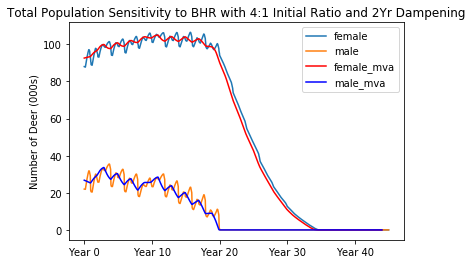

In [40]:
## ## Initalized with equal male/female populations #
#################################################
yrs = 45

t = np.linspace(0,365*yrs,365*yrs) # 18250 days  or 50 years
K,C,d,mortality,hbr,rf = [.2*700000,.2*22,.2,.18,.6,1]


f_ratio = 4
m_ratio = 1

sol = odeint(deerModelDampenedHunting2, 
             [round(f_ratio*total_pop/(f_ratio + m_ratio),0), 
              round(m_ratio*total_pop/(f_ratio + m_ratio),0)],
             t, args = (K,C,d,mortality,hbr,rf,))/1e3

plt.plot(sol[:,0], label = "female")
plt.plot(sol[:,1],  label = "male")
#plt.plot(sol[:,0] + sol[:,1],  label = "population")

mva_female = np.convolve(sol[:,0], np.ones((365,))/365, mode='valid')
plt.plot(mva_female, label = "female_mva", color = 'red')

mva_male = np.convolve(sol[:,1], np.ones((365,))/365, mode='valid')
plt.plot(mva_male, label = "male_mva", color = 'blue')

plt.title('Total Population Sensitivity to BHR with 4:1 Initial Ratio and 2Yr Dampening')
plt.ylabel('Number of Deer (000s)')

x_ticks = [day for day in range(0,365*yrs,1) if day%(365*10) == 0] # Only pull out full years
x_labels = ['Year ' + str(i*10) for i in range(len(x_ticks))]
plt.xticks(x_ticks, x_labels)

plt.legend()

### 3.6 Analyze HBR Sensitivity for 2-Year Dampening for 4:1 Ratio

In [84]:
sol = []
yrs = 100
for rate in range(10,60,5):
    
    t = np.linspace(0,365*yrs,365*yrs) # 18250 days  or 50 years
    K,C,d,mortality,hbr,rf = [.2*700000,.2*22,.2,.18,(rate/100),1]

    sol.append(odeint(deerModelDampenedHunting2, 
             [round(f_ratio*total_pop/(f_ratio + m_ratio),0), 
              round(m_ratio*total_pop/(f_ratio + m_ratio),0)],
             t, args = (K,C,d,mortality,hbr,rf,))/1e3)

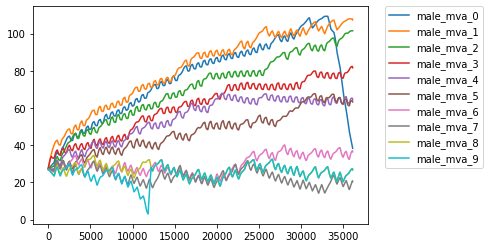

In [85]:
male = [item[:,1] for item in sol]
#plt.plot(male[2])
for i in range(len(male)):
    mva_male = np.convolve(male[i], np.ones((365,))/365, mode='valid')
    plt.plot(mva_male, label = ("male_mva_" + str(i)))
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

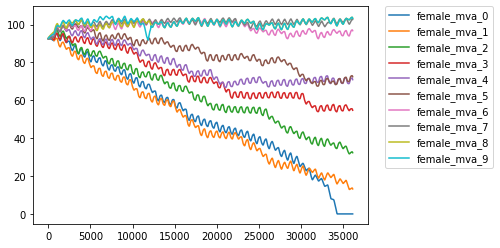

In [86]:
female = [item[:,0]  for item in sol]
for i in range(len(female)):
    mva_female = np.convolve(female[i], np.ones((365,))/365, mode='valid')
    plt.plot(mva_female, label = ("female_mva_" + str(i)))
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

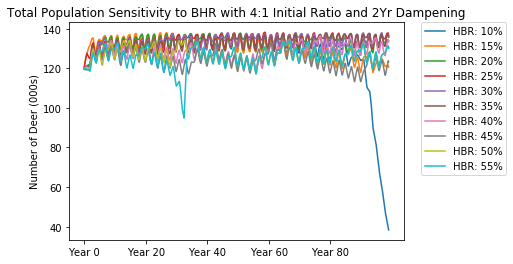

In [87]:
for i in range(len(female)):
    total = male[i] + female[i]
    mva_total = np.convolve(total, np.ones((365,))/365, mode='valid')
    
    mva_total = zero_to_nan(mva_total)
    
    if (mva_total[len(mva_total)-1]>0):
        plt.plot(mva_total, label = ("HBR: " + str((i*5 + 10)) + "%"))
    else: plt.plot(mva_total, label = ("HBR: " + str((i*5 + 10)) + "%"), color = "gray")#, alpha = 0.5)
        
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.title('Total Population Sensitivity to BHR with 4:1 Initial Ratio and 2Yr Dampening')
    plt.ylabel('Number of Deer (000s)')

    x_ticks = [day for day in range(0,365*yrs,1) if day%(365*20) == 0] # Only pull out full years
    x_labels = ['Year ' + str(i*20) for i in range(len(x_ticks))]
    plt.xticks(x_ticks, x_labels)

<hr style="border:1px solid gray"> </hr>

## 4 Analysis 3:2 Population Split 

#### K,C,d,mortality,hbr,rf = [.2(700000),.2(22),.2,.18,.6,1]
#### Female (3) : Male (2)


## BEST POPULATION SPLIT FOR 100 YEAR HEARD - more invariable to hbr rates - populations last longer with an uneven split but it has to be close

### 4.1 Baseline Herd Survival for 3:2 Ratio


([<matplotlib.axis.XTick at 0x28c412e0d88>,
 <a list of 5 Text xticklabel objects>)

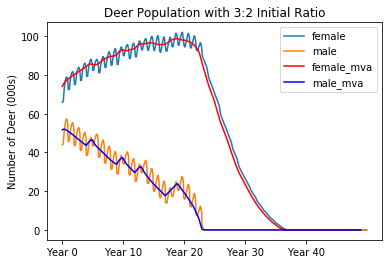

In [110]:
## ## Initalized with equal male/female populations #
#################################################
yrs = 50

f_ratio = 3
m_ratio = 2

t = np.linspace(0,365*yrs,365*yrs) # 18250 days  or 50 years
K,C,d,mortality,hbr,rf = [.2*700000,.2*22,.2,.18,.6,1]

sol = odeint(deerModel,
             [round(f_ratio*total_pop/(f_ratio + m_ratio),0), 
              round(m_ratio*total_pop/(f_ratio + m_ratio),0)], 
             t, args = (K,C,d,mortality,hbr,rf,))/1e3

plt.plot(sol[:,0], label = "female")
plt.plot(sol[:,1],  label = "male")

mva_female = np.convolve(sol[:,0], np.ones((365,))/365, mode='valid')
plt.plot(mva_female, label = "female_mva", color = 'red')


mva_male = np.convolve(sol[:,1], np.ones((365,))/365, mode='valid')
plt.plot(mva_male, label = "male_mva", color = 'blue')

plt.title('Deer Population with 3:2 Initial Ratio')

plt.legend()

plt.ylabel('Number of Deer (000s)')

x_ticks = [day for day in range(0,365*yrs,1) if day%(365*10) == 0] # Only pull out full years
x_labels = ['Year ' + str(i*10) for i in range(len(x_ticks))]
plt.xticks(x_ticks, x_labels)

### 4.2 Analyze HBR Sensitivity for Baseline 3:2 Ratio

In [98]:
f_ratio

3

In [99]:
sol = []
yrs = 100
for rate in range(10,60,5):
    
    t = np.linspace(0,365*yrs,365*yrs) # 18250 days  or 50 years
    K,C,d,mortality,hbr,rf = [.2*700000,.2*22,.2,.18,(rate/100),1]

    sol.append(odeint(deerModel,
             [round(f_ratio*total_pop/(f_ratio + m_ratio),0), 
              round(m_ratio*total_pop/(f_ratio + m_ratio),0)], 
             t, args = (K,C,d,mortality,hbr,rf,))/1e3)

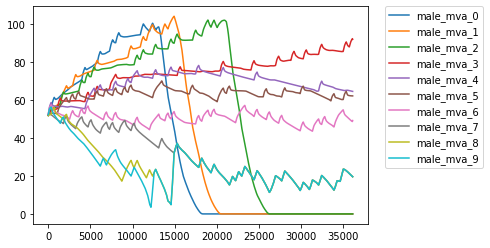

In [100]:
male = [item[:,1] for item in sol]
#plt.plot(male[2])
for i in range(len(male)):
    mva_male = np.convolve(male[i], np.ones((365,))/365, mode='valid')
    plt.plot(mva_male, label = ("male_mva_" + str(i)))
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

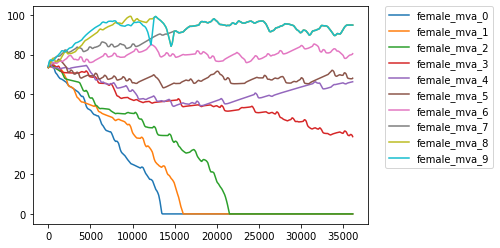

In [101]:
female = [item[:,0]  for item in sol]
for i in range(len(female)):
    mva_female = np.convolve(female[i], np.ones((365,))/365, mode='valid')
    plt.plot(mva_female, label = ("female_mva_" + str(i)))
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

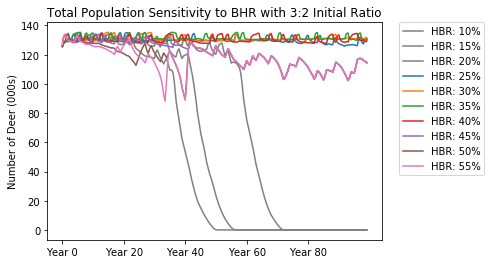

In [102]:
for i in range(len(female)):
    total = male[i] + female[i]
    mva_total = np.convolve(total, np.ones((365,))/365, mode='valid')
    
    mva_total = zero_to_nan(mva_total)
    
    if (mva_total[len(mva_total)-1]>0):
        plt.plot(mva_total, label = ("HBR: " + str((i*5 + 10)) + "%"))
    else: plt.plot(mva_total, label = ("HBR: " + str((i*5 + 10)) + "%"), color = "gray")#, alpha = 0.5)
        
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.title('Total Population Sensitivity to BHR with 3:2 Initial Ratio')
    plt.ylabel('Number of Deer (000s)')

    x_ticks = [day for day in range(0,365*yrs,1) if day%(365*20) == 0] # Only pull out full years
    x_labels = ['Year ' + str(i*20) for i in range(len(x_ticks))]
    plt.xticks(x_ticks, x_labels)

<hr style="border:1px solid gray"> </hr>

### 4.3 5-Year Dampening for 3:2 Ratio

([<matplotlib.axis.XTick at 0x28c4984d788>,
 <a list of 5 Text xticklabel objects>)

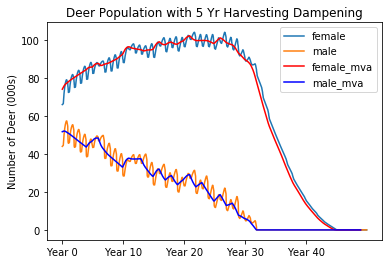

In [116]:
## ## Initalized with equal male/female populations #
#################################################
yrs = 50

f_ratio = 3
m_ratio = 2

t = np.linspace(0,365*yrs,365*yrs) # 18250 days  or 50 years
K,C,d,mortality,hbr,rf = [.2*700000,.2*22,.2,.18,.6,1]

sol = odeint(deerModelDampenedHunting,
             [round(f_ratio*total_pop/(f_ratio + m_ratio),0), 
              round(m_ratio*total_pop/(f_ratio + m_ratio),0)], 
             t, args = (K,C,d,mortality,hbr,rf,))/1e3

plt.plot(sol[:,0], label = "female")
plt.plot(sol[:,1],  label = "male")

mva_female = np.convolve(sol[:,0], np.ones((365,))/365, mode='valid')
plt.plot(mva_female, label = "female_mva", color = 'red')


mva_male = np.convolve(sol[:,1], np.ones((365,))/365, mode='valid')
plt.plot(mva_male, label = "male_mva", color = 'blue')

plt.title('Deer Population with 5 Yr Harvesting Dampening')

plt.legend()

plt.ylabel('Number of Deer (000s)')

x_ticks = [day for day in range(0,365*yrs,1) if day%(365*10) == 0] # Only pull out full years
x_labels = ['Year ' + str(i*10) for i in range(len(x_ticks))]
plt.xticks(x_ticks, x_labels)

### 4.4 Analyze HBR Sensitivity 5-Year Dampening for 3:2 Ratio

In [117]:
sol = []
yrs = 100
for rate in range(10,60,5):
    
    t = np.linspace(0,365*yrs,365*yrs) # 18250 days  or 50 years
    K,C,d,mortality,hbr,rf = [.2*700000,.2*22,.2,.18,(rate/100),1]

    sol.append(odeint(deerModelDampenedHunting,
             [round(f_ratio*total_pop/(f_ratio + m_ratio),0), 
              round(m_ratio*total_pop/(f_ratio + m_ratio),0)], 
             t, args = (K,C,d,mortality,hbr,rf,))/1e3)

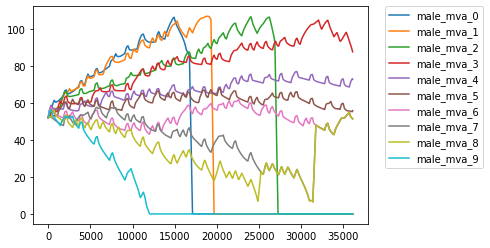

In [118]:
male = [item[:,1] for item in sol]
for i in range(len(male)):
    mva_male = np.convolve(male[i], np.ones((365,))/365, mode='valid')
    plt.plot(mva_male, label = ("male_mva_" + str(i)))
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

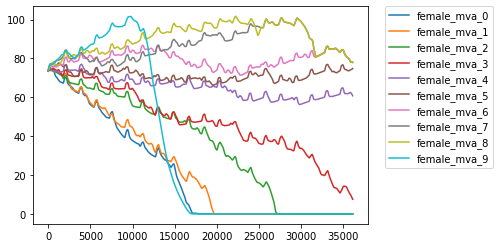

In [119]:
female = [item[:,0]  for item in sol]
for i in range(len(female)):
    mva_female = np.convolve(female[i], np.ones((365,))/365, mode='valid')
    plt.plot(mva_female, label = ("female_mva_" + str(i)))
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

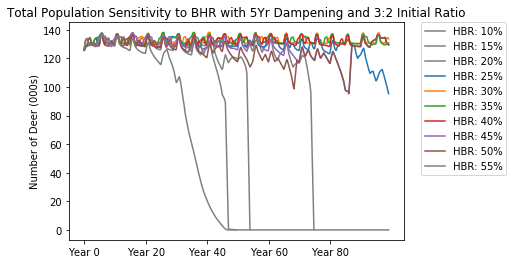

In [120]:
for i in range(len(female)):
    total = male[i] + female[i]
    mva_total = np.convolve(total, np.ones((365,))/365, mode='valid')
    
    mva_total = zero_to_nan(mva_total)
    
    if (mva_total[len(mva_total)-1]>0):
        plt.plot(mva_total, label = ("HBR: " + str((i*5 + 10)) + "%"))
    else: plt.plot(mva_total, label = ("HBR: " + str((i*5 + 10)) + "%"), color = "gray")#, alpha = 0.5)
        
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.title('Total Population Sensitivity to BHR with 5Yr Dampening and 3:2 Initial Ratio')
    plt.ylabel('Number of Deer (000s)')

    x_ticks = [day for day in range(0,365*yrs,1) if day%(365*20) == 0] # Only pull out full years
    x_labels = ['Year ' + str(i*20) for i in range(len(x_ticks))]
    plt.xticks(x_ticks, x_labels)

<hr style="border:1px solid gray"> </hr>

### 4.5 2-Year Dampening for 3:2 Ratio

In [121]:
yrs = 80

t = np.linspace(0,365*yrs,365*yrs) # 18250 days  or 50 years
K,C,d,mortality,hbr,rf = [.2*700000,.2*22,.2,.18,.6,1]

sol = odeint(deerModelDampenedHunting2,
             [round(f_ratio*total_pop/(f_ratio + m_ratio),0), 
              round(m_ratio*total_pop/(f_ratio + m_ratio),0)], 
             t, args = (K,C,d,mortality,hbr,rf,))/1e3

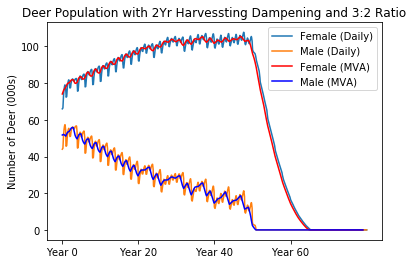

3 2


In [122]:
plt.plot(sol[:,0], label = "Female (Daily)")
plt.plot(sol[:,1],  label = "Male (Daily)")
#plt.plot(sol[:,0] + sol[:,1],  label = "population")

mva_female = np.convolve(sol[:,0], np.ones((365,))/365, mode='valid')
plt.plot(mva_female, label = "Female (MVA)", color = 'red')

mva_male = np.convolve(sol[:,1], np.ones((365,))/365, mode='valid')
plt.plot(mva_male, label = "Male (MVA)", color = 'blue')

plt.title('Deer Population with 2Yr Harvessting Dampening and 3:2 Ratio')
plt.legend()

plt.ylabel('Number of Deer (000s)')

x_ticks = [day for day in range(0,365*yrs,1) if day%(365*20) == 0] # Only pull out full years
x_labels = ['Year ' + str(i*20) for i in range(len(x_ticks))]
plt.xticks(x_ticks, x_labels)
plt.show()

print(f_ratio, m_ratio)

### 4.6 Analyze HBR Sensitivity for 2-Year Dampening for 3:2 Ratio

In [123]:
sol = []
yrs = 100
for rate in range(10,60,5):
    
    t = np.linspace(0,365*yrs,365*yrs) 
    K,C,d,mortality,hbr,rf = [.2*700000,.2*22,.2,.18,(rate/100),1]

    sol.append(odeint(deerModelDampenedHunting2,
             [round(f_ratio*total_pop/(f_ratio + m_ratio),0), 
              round(m_ratio*total_pop/(f_ratio + m_ratio),0)], 
             t, args = (K,C,d,mortality,hbr,rf,))/1e3)

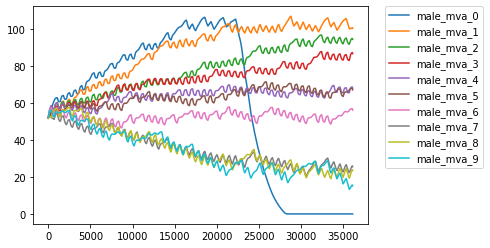

In [124]:
male = [item[:,1] for item in sol]
#plt.plot(male[2])
for i in range(len(male)):
    mva_male = np.convolve(male[i], np.ones((365,))/365, mode='valid')
    plt.plot(mva_male, label = ("male_mva_" + str(i)))
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

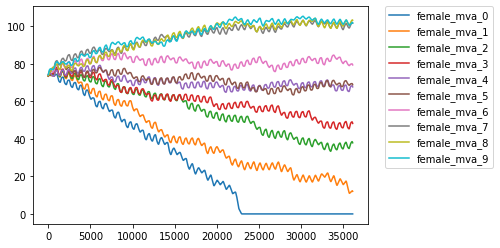

In [125]:
female = [item[:,0]  for item in sol]
for i in range(len(female)):
    mva_female = np.convolve(female[i], np.ones((365,))/365, mode='valid')
    plt.plot(mva_female, label = ("female_mva_" + str(i)))
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

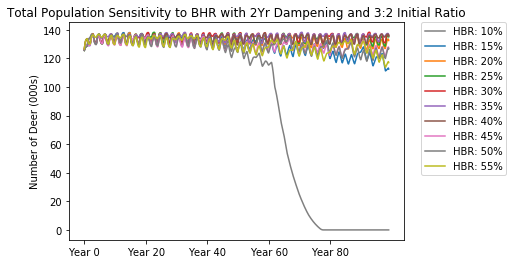

In [126]:
for i in range(len(female)):
    total = male[i] + female[i]
    mva_total = np.convolve(total, np.ones((365,))/365, mode='valid')
    
    mva_total = zero_to_nan(mva_total)
    
    if (mva_total[len(mva_total)-1]>0):
        plt.plot(mva_total, label = ("HBR: " + str((i*5 + 10)) + "%"))
    else: plt.plot(mva_total, label = ("HBR: " + str((i*5 + 10)) + "%"), color = "gray")#, alpha = 0.5)
        
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.title('Total Population Sensitivity to BHR with 2Yr Dampening and 3:2 Initial Ratio')
    plt.ylabel('Number of Deer (000s)')

    x_ticks = [day for day in range(0,365*yrs,1) if day%(365*20) == 0] # Only pull out full years
    x_labels = ['Year ' + str(i*20) for i in range(len(x_ticks))]
    plt.xticks(x_ticks, x_labels)

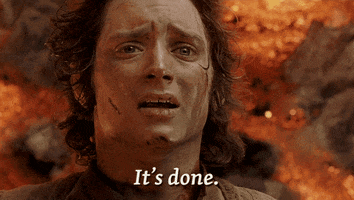